# Example: Computing Stylized Facts for Equity Log Return Data
Fill me in

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem.
* See the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl) for additional information on functions and types used in this material. 

In [3]:
include("Include.jl")

MyMarketDataSet (generic function with 1 method)

## Prerequisites: Load and clean the historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2018` until `12-29-2023`, along with data for a few exchange-traded funds and volatility products during that time. We load the `orignal_dataset` by calling the `MyMarketDataSet()` function:

In [5]:
original_dataset = MyMarketDataSet() |> x-> x["dataset"];

### Clean the data
Not all tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquisition or de-listing events. Let's collect only those tickers with the maximum number of trading days.
* First, let's compute the number of records for a company that we know has a maximum value, e.g., `AAPL,` and save that value in the `maximum_number_trading_days` variable:

In [7]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

Now, iterate through the `original_dataset` and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [9]:
dataset = Dict{String,DataFrame}();
for (ticker, data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end
dataset

Dict{String, DataFrame} with 460 entries:
  "NI"   => 1508×8 DataFrame…
  "EMR"  => 1508×8 DataFrame…
  "CTAS" => 1508×8 DataFrame…
  "HSIC" => 1508×8 DataFrame…
  "KIM"  => 1508×8 DataFrame…
  "PLD"  => 1508×8 DataFrame…
  "IEX"  => 1508×8 DataFrame…
  "BAC"  => 1508×8 DataFrame…
  "CBOE" => 1508×8 DataFrame…
  "EXR"  => 1508×8 DataFrame…
  "NCLH" => 1508×8 DataFrame…
  "CVS"  => 1508×8 DataFrame…
  "DRI"  => 1508×8 DataFrame…
  "DTE"  => 1508×8 DataFrame…
  "ZION" => 1508×8 DataFrame…
  "AVY"  => 1508×8 DataFrame…
  "EW"   => 1508×8 DataFrame…
  "EA"   => 1508×8 DataFrame…
  "NWSA" => 1508×8 DataFrame…
  "CAG"  => 1508×8 DataFrame…
  "GPC"  => 1508×8 DataFrame…
  "FCX"  => 1508×8 DataFrame…
  "GILD" => 1508×8 DataFrame…
  "UNP"  => 1508×8 DataFrame…
  "CDW"  => 1508×8 DataFrame…
  ⋮      => ⋮

Lastly, let's get a list of firms that we have in cleaned up `dataset`, and save it ib the `list_of_all_tickers` array

In [11]:
list_of_all_tickers = keys(dataset) |> collect |> sort;

### Constants
Fill me in

In [13]:
Δt = (1/252);

## Task 1: Compute the log growth rate array
In this task, we will compute the log growth rate array for every ticker in the `dataset` using [the `log_growth_matrix(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.log_growth_matrix). 
* The [`log_growth_matrix(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.log_growth_matrix) takes `dataset` $\mathcal{D}$ and a list of firms $\mathcal{L}$ and computes the growth rate values for each firm as a function of time. The data is returned as a $\mathcal{D}_{i}\times\dim\mathcal{L}$ array (time on the rows, firm $i$ on the columns). We store the data in the `all_firms_growth_matrix::Array{Float64,2}` variable:

In [15]:
all_firms_growth_matrix = log_growth_matrix(dataset, list_of_all_tickers, Δt = Δt);

### Visualize
Fill me in

In [64]:
ticker_to_visualize = "MET";

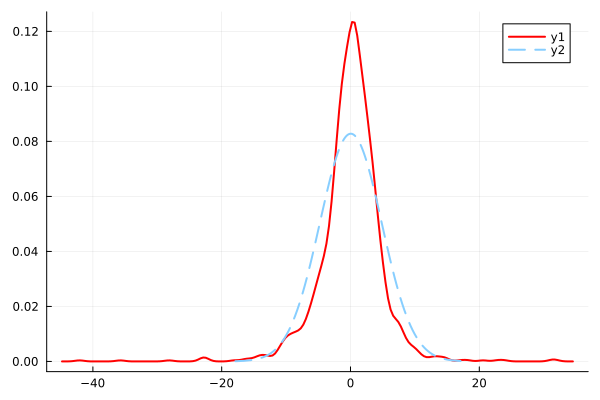

In [66]:
let
    μ = findfirst(ticker -> ticker == ticker_to_visualize,list_of_all_tickers) |> i -> all_firms_growth_matrix[:,i];
    density(μ, c=:red, lw=2)

    # fit a Normal, and plot that -
    d = fit_mle(Normal, μ);
    plot!(d, c=:skyblue1, lw = 2, ls = :dash)
end

## Task 2: Is the log growth rate Normally distributed?
In this task, we explore one of the central stylized facts: returns (growth) are not normally distributed. Return distributions have `fat tails,` i.e., the density of the returns near zero is smaller than that of a normal distribution, with more density on the tails of the distribution. 

* Let's develop a procedure based on the [Anderson–Darling test](https://en.wikipedia.org/wiki/Anderson–Darling_test) and the [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) exported by the [HypothesisTests.jl package](https://github.com/JuliaStats/HypothesisTests.jl) to estimate which firms in the dataset $\mathcal{D}$ follow a [Laplace distribution](https://en.wikipedia.org/wiki/Laplace_distribution)

Suppose we define the class set $\mathcal{C}\equiv\left\{\text{normal},\text{laplace},\text{undefined}\right\}$ to describe the possible types of returns. Classify the shape of the returns for each of the firms in the `dataset` $\mathcal{D}$, where for each firm $i$ we compute a classification $c_{i}\in\left\{\text{normal},\text{laplace},\text{undefined}\right\}$. For each statistical test, use a `pvalue = 0.0001` cutoff.
* `Normal`: Test for normality of the return for firm $i$ using a one-sample [Anderson–Darling test](https://en.wikipedia.org/wiki/Anderson–Darling_test).
* `Laplace`: If the return for firm $i$ is `NOT` normal, use a one-sample [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) and a one-sample [Anderson–Darling test](https://en.wikipedia.org/wiki/Anderson–Darling_test) to determine if the return for firm $i$ follows a `Laplace` distribution. 
* `Undefined`: If both the tests fail, classify firm $i$ as `undefined.`

In [17]:
return_classification_dictionary = Dict{String, Symbol}();
p_value_cutoff = 0.00001;
for i ∈ eachindex(list_of_all_tickers)
    
    ticker = list_of_all_tickers[i];
    samples = all_firms_growth_matrix[:,i] |> x -> unique(x);
    
    d_normal = fit_mle(Normal, samples)
    d_laplace = fit_mle(Laplace, samples)

    AD_test_result = OneSampleADTest(samples,d_normal) |> pvalue
    if (AD_test_result > p_value_cutoff) # support H0
        return_classification_dictionary[ticker] = :normal
    else
        KS_test_result_laplace = ExactOneSampleKSTest(samples, d_laplace) |> pvalue
        AD_test_result_laplace = OneSampleADTest(samples,d_laplace) |> pvalue
        if (KS_test_result_laplace > p_value_cutoff && AD_test_result_laplace > p_value_cutoff)
            return_classification_dictionary[ticker] = :laplace
        else
            return_classification_dictionary[ticker] = :undefined
        end
    end
end
return_classification_dictionary;

### What is the fraction of `normal,` `Laplace,` or `undefined` return distributions?

In [19]:
fraction_normal = findall(x->x==:normal, return_classification_dictionary) |> length |> 
    x -> x/length(list_of_all_tickers) |> x-> round(x,digits=3) |> x-> *(x,100.0)
println("Approximately $(fraction_normal)% of the firms in the dataset have Normally distributed returns")

Approximately 8.3% of the firms in the dataset have Normally distributed returns


In [20]:
fraction_laplace = findall(x->x==:laplace, return_classification_dictionary) |> length |> 
    x -> x/length(list_of_all_tickers) |> x-> round(x,digits=3) |> x-> *(x,100.0)
println("Approximately $(fraction_laplace)% of the firms in the dataset have Laplace distributed returns")

Approximately 91.7% of the firms in the dataset have Laplace distributed returns


In [21]:
fraction_undefined = findall(x->x==:undefined, return_classification_dictionary) |> length |> 
    x -> x/length(list_of_all_tickers) |> x-> round(x,digits=3) |> x-> *(x,100.0)
println("Approximately $(fraction_undefined)% of the firms in the dataset have undefined returned distributions")

Approximately 0.0% of the firms in the dataset have undefined returned distributions


## Task 3: Autocorrelation and Volatility clustering
This task compares the stylized facts for the observed out-of-sample and simulated excess growth datasets. In particular, we'll look at two stylized facts, namely, the autocorrelation of the excess growth rate and the volatility clustering, i.e., the autocorrelation of the absolute value of the excess growth rate.

### Autocorrelation
Let's look at the [autocorrelation as a function of the time lag](https://en.wikipedia.org/wiki/Autocorrelation) for the data in the `out_of_sample_dataset` and a randomly selected trajectory from the `out_of_sample_decoded_archive` array. 

#### Summary
`Unhide` the code block below to see how we computed and plotted the [autocorrelation function](https://en.wikipedia.org/wiki/Autocorrelation) for the simulated and observed out-of-sample dataset.
* The [random walk hypothesis](https://en.wikipedia.org/wiki/Random_walk_hypothesis) suggests that for lags greater than `1`, the autocorrelation of the return should be zero. We tested this idea using the observed out-of-sample growth rates in the `out_of_sample_dataset::Array{Float64,1}` array and the simulated growth rates in the `out_of_sample_decoded_archive` array.
* The observed (orange) and simulated (blue) excess growth rates show a near-zero autocorrelation at a 99% confidence level as a function of the lag (day), with the exception of a few lags in the first hundred days.
* Although both the data and the model show a few violations of the autocorrelation hypothesis, these violations are weak.

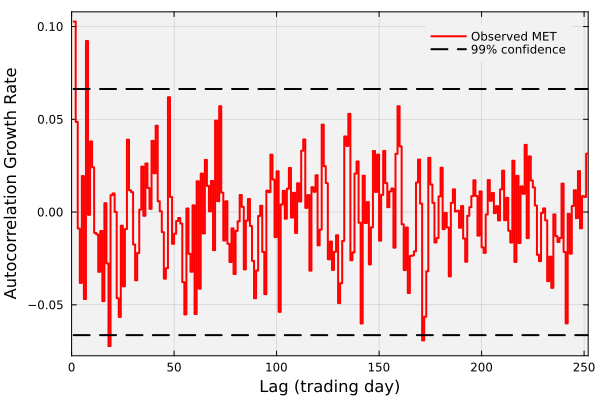

In [117]:
let

    # generate a random index -
    i = findfirst(ticker -> ticker == ticker_to_visualize,list_of_all_tickers);
    number_of_steps = maximum_number_trading_days - 1;
    max_number_of_steps_x = 252
    X = all_firms_growth_matrix[:,i];
    
    plot(autocor(X, (1:(number_of_steps - 1) |> collect)), label="Observed $(ticker_to_visualize)", lw=2, c=:red, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, linetype=:steppost,
     xlims=(0,max_number_of_steps_x))
    
    LINE = (2.576/sqrt(number_of_steps))*ones(number_of_steps-1);
    plot!(LINE, label="99% confidence", lw=2, c=:black, ls=:dash)
    plot!(-LINE, label="", lw=2, c=:black, ls=:dash)
    xlabel!("Lag (trading day)", fontsize=18)
    ylabel!("Autocorrelation Growth Rate", fontsize=18)

    # uncomment me to save to file -
    # savefig(joinpath(_PATH_TO_FIGS, "Fig-Autocorrelation-HMM-GenModel-$(ticker).pdf"));
end

### Volatility clustering
Next, let's consider volatility clustering. Volatility clustering is determined by examining the autocorrelation of the absolute values of the excess growth rate for different lag values. In actual data, we expect a positive absolute autocorrelation for short lags. Volatility clustering indicates that periods of high volatility, such as significant changes in returns, tend to occur close together in time.

#### Summary
`Unhide` the code block below to see how we computed and plotted the [autocorrelation function](https://en.wikipedia.org/wiki/Autocorrelation) for the absolute values of the simulated and observed out-of-sample excess growth rates.
* The observed out-of-sample dataset (orange line) shows a positive autocorrelation for lags less than approximately `10 days` at a 99% confidence level. This suggests the market has a memory of approximately 10 days or less following large disruptions.
* The excess growth rate trajectories produced by the Markov model (blue line) don't show volatility clustering; thus, this model (at least as it's currently implemented) will not capture the clustering of high-volatility events.

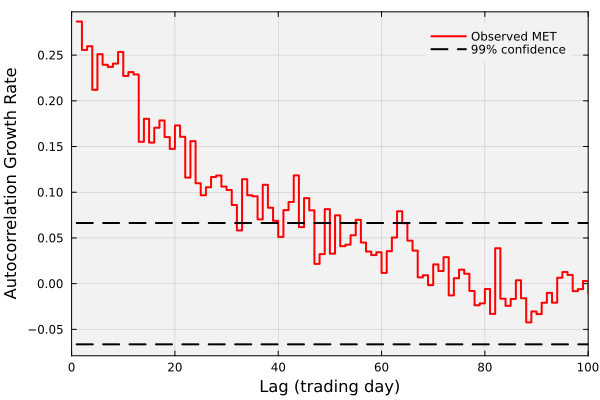

In [121]:
let

    # generate a random index -
    i = findfirst(ticker -> ticker == ticker_to_visualize,list_of_all_tickers);
    number_of_steps = maximum_number_trading_days - 1;
    max_number_of_steps_x = 100
    X = abs.(all_firms_growth_matrix[:,i]);
    
    plot(autocor(X, (1:(number_of_steps - 1) |> collect)), label="Observed $(ticker_to_visualize)", lw=2, c=:red, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, linetype=:steppost,
    xlims=(0,max_number_of_steps_x))
    
    LINE = (2.576/sqrt(number_of_steps))*ones(number_of_steps-1);
    plot!(LINE, label="99% confidence", lw=2, c=:black, ls=:dash)
    plot!(-LINE, label="", lw=2, c=:black, ls=:dash)
    xlabel!("Lag (trading day)", fontsize=18)
    ylabel!("Autocorrelation Growth Rate", fontsize=18)

    
    # uncomment me to save to file -
    # savefig(joinpath(_PATH_TO_FIGS, "Fig-Autocorrelation-HMM-GenModel-$(ticker).pdf"));
end

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.